In [1]:
library(purrr)
library(tidyverse)
library(Seurat)
library(ggplot2)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v dplyr   1.0.4
v tibble  3.0.6     v stringr 1.4.0
v tidyr   1.1.2     v forcats 0.5.1
v readr   1.4.0     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat':
  method     from
  print.boxx cli 

Attaching SeuratObject



In [2]:
source('paths.R')
source('factors.R')
source('misc.R')

In [3]:
##
## Loading Cell Ranger matrices (per sample) and merging
##

H5_EXTENSION <- '.h5'

matrix_path <- function(sample_num, h5=TRUE) {
    extension <- if (h5) H5_EXTENSION else ''
    filename <- sprintf('S%d.filtered_matrix%s', sample_num, extension)
    fullpath <- path_at('in', 'matrices')(filename)
    return(fullpath)
}

load_matrix <- function(path) {
    read <- if (path %>% str_ends(H5_EXTENSION)) Read10X_h5 else Read10X
    path %>% read() %>% CreateSeuratObject()
}

set_library_id <- function(obj, library_id) (
    AddMetaData(obj, library_id, 'library_id')
)

set_cells_suffix <- function(matrix, new_suffix) {
    stripped <- Cells(matrix) %>% str_replace('-.+$', '')
    new.names <- sprintf('%s-%s', stripped, new_suffix)
    RenameCells(matrix, new.names = new.names)
}

merge_seurat_objects <- function (list_) {
    first_ <- first(list_)
    list_[[1]] <- NULL
    return(merge(first_, list_))
}


In [4]:
##
## Cell and gene filtering
##

VIRAL_GENES_PREFIX <- '^InfluenzaA-'
MITO_GENES_PREFIX <- '^MT-'

attach_pct_mito_and_pct_viral  <- function(obj) (
    obj
    %>% PercentageFeatureSet(pattern=MITO_GENES_PREFIX, col.name='pct_mito')
    %>% PercentageFeatureSet(pattern=VIRAL_GENES_PREFIX, col.name='pct_viral')
)

filter_cells <- function(obj, min_rna_count=10000, max_pct_mito=15) {
    retained <- WhichCells(obj, expression=(nCount_RNA > min_rna_count) & (pct_mito < max_pct_mito))
    return(obj[, retained])
}

filter_genes <- function(obj, min_cells = 10) {
    non_viral <- str_starts(rownames(obj), VIRAL_GENES_PREFIX, negate=TRUE)
    with_at_least_min_cells <- Matrix::rowSums(obj@assays$RNA@counts > 0) >= min_cells
    genes.mask <- non_viral & with_at_least_min_cells
    return(obj[genes.mask, ])
}

attach_nCount_RNA_all_genes <- function(obj) {
    x <- obj@meta.data$nCount_RNA
    AddMetaData(obj, x, 'nCount_RNA_all_genes')
}

In [5]:
##
## Checking that the cell IDs and the gene names are as expected
##

check_cells_hash <- function(obj) {
    hash <- Cells(obj) %>% sort() %>% paste(collapse="") %>% digest::sha1()
    stopifnot(hash == 'c626cdc7fbefbf1252023e2016cd17a70b7f8f76')
    obj
}

check_genes_hash <- function(obj) {
    hash <- rownames(obj) %>% sort() %>% paste(collapse="") %>% digest::sha1()
    stopifnot(hash == 'e57f172f02a947c1cb6b169bd7310ac6f4a4fdee')
    obj
}

In [6]:
##
## Attaching library metadata as well as condition/treatment dummies
##

attach_condition_factors <- function(obj) {
    cf <- (
        obj
        %>% get_metadata()
        %>% left_join(conditions_meta, by='library_id', )
        %>% right_join(tibble(barcode = Cells(obj), by='barcode'))
    )
    (
        obj
        %>% AddMetaData(cf$condition, 'condition')
        %>% AddMetaData(cf$condition_text, 'condition_text')
        %>% AddMetaData(cf$condition_short, 'condition_short')
    )
}

attach_condition_dummies <- function(obj) {
    cl <- obj@meta.data$condition %>% tolower()
    (
        obj
        %>% AddMetaData(grepl('infected', cl), 'IAV')
        %>% AddMetaData(grepl('sln', cl), 'SLN_CD')
        %>% AddMetaData(grepl('ifn', cl), 'IFN_L1')
        %>% AddMetaData(grepl('ifn|sln', cl), 'TREATED')
    )
}

In [7]:
##
## Attaching precomputed t-SNE projection
##
## See 98-global-clustering.ipynb
##

load_tsne_pcs <- function(barcodes) {
    input <- read_csv(path_at('in', 'precomputed')('tsne_pcs.csv'))
    input <- tibble(barcode=barcodes) %>% left_join(input)
    coords <- input %>% select_if(is.numeric)
    mat <- as.matrix(coords)
    colnames(mat) <- names(coords)
    rownames(mat) <- input %>% pull(barcode)
    return(CreateDimReducObject(mat, assay='SCT', global=TRUE, key = 'tSNE_'))
}

attach_tsne_pcs <- function(obj) {
    obj@reductions$tsne_pcs <- load_tsne_pcs(Cells(obj))
    return(obj)
}

In [8]:
##
## Attaching precomputed clustering results (global)
##
## See 98-global-clustering.ipynb
##

.gcct_coltypes <- cols(
    barcode = col_character(),
    cell_type = col_character(),
    global_clusters = col_character()
)

load_global_clusters_and_cell_types <- function() (
    path_at('in', 'precomputed')('global_clusters_and_cell_types.csv')
    %>% read_csv(col_types = .gcct_coltypes)
    %>% mutate(global_clusters = global_clusters %>% factor(global_clusters_levels, ordered=TRUE))
    %>% mutate(cell_type = cell_type %>% factor(cell_type_levels, ordered=TRUE))
)

attach_global_clusters_and_cell_types <- function(obj) {
    barcodes <- get_metadata(obj) %>% select(barcode)
    gcct <- load_global_clusters_and_cell_types()
    gcct <- left_join(barcodes, gcct, by='barcode')
    (
        obj
        %>% AddMetaData(gcct$global_clusters, 'global_clusters')
        %>% AddMetaData(gcct$cell_type, 'cell_type')
    )
}

In [9]:
##
## Attaching precomputed subclustering results (within cell types)
##
## See 99-subclustering.ipynb
##

load_subclusters <- function(cell_type, colname) (
    path_at('in', 'precomputed')(cell_type, 'subclusters', 'csv')
    %>% read_csv()
    %>% mutate_at(colname, ~ .x %>% factor(subcluster_metas[[cell_type]]$subcluster, ordered=TRUE))
)

attach_subclusters <- function(obj) {
    barcodes <- get_metadata(obj) %>% select(barcode)
    for (ct in cell_type_levels) {
        colname <- paste(ct, 'subcluster', sep='_')
        subc_df <- left_join(barcodes, load_subclusters(ct, colname), by='barcode')
        obj <- AddMetaData(obj, subc_df[[colname]], colname)
    }
    return(obj)
}

In [10]:
##
## Splitting cells into viral load classes (VLCs)
##

estimate_vlc_thresholds <- function(m, exclude_undefined_global_cluster=TRUE) {
    if (exclude_undefined_global_cluster) {
        m <- m %>% filter(!is.na(cell_type))
    }
    FV_MIN_NONZERO <- m %>% filter(frac_viral > 0) %>% pull(frac_viral) %>% min()
    FV_Q99_UNINFECTED <- m %>% filter(!IAV & frac_viral > 0) %>% pull(frac_viral) %>% quantile(0.99)
    FV_MIN_UNTREATED <- m %>% filter(IAV & !TREATED) %>% pull(frac_viral) %>% min()
    FV_Q75_INFECTED_UNTREATED <- m %>% filter(IAV & !TREATED) %>% pull(frac_viral) %>% quantile(0.75)
    c(
        `Zero|Noise` = FV_MIN_NONZERO,
        `Noise|Low` = FV_Q99_UNINFECTED,
        `Low|Medium` = FV_MIN_UNTREATED,
        `Medium|High` = FV_Q75_INFECTED_UNTREATED
    )
}

attach_frac_viral  <- function(obj) {
    pct_viral <- obj@meta.data$pct_viral %>% replace_na(0)
    AddMetaData(obj, pct_viral/100, 'frac_viral')
}

attach_viral_load_classes <- function(obj) {
    vlc_thresholds <- estimate_vlc_thresholds(obj@meta.data)
    vlc_breaks <- c(-Inf, vlc_thresholds, Inf)
    vlc <- obj$frac_viral %>% cut(breaks=vlc_breaks, labels=vlc_levels, ordered=TRUE, right=FALSE)
    AddMetaData(obj, vlc, 'viral_load_class')
}

In [11]:
filtered <- (
    
    # Create a list of sample IDs (named by sample IDs as well)
    seq(1, 6)
    %>% set_names()
    
    # Load sample-level results from CellRanger
    %>% map(matrix_path)
    %>% map(load_matrix)
    
    # Tag the libraries and barcodes before merging
    %>% imap(~set_library_id(.x, as.integer(.y)))
    %>% imap(~set_cells_suffix(.x, .y))
    
    # Merge into a single Seurat object
    %>% merge_seurat_objects()
    
    # Filter cells and genes
    %>% attach_pct_mito_and_pct_viral()
    %>% filter_cells()
    %>% attach_nCount_RNA_all_genes()
    %>% filter_genes()
    
    # Check that retained genes and cells are a expected
    %>% check_cells_hash()
    %>% check_genes_hash()
    
    # Attach condition identifiers (from library IDs) and dummies
    %>% attach_condition_factors()
    %>% attach_condition_dummies()
    
    # Attach precomputed (sub)clusters and the t-SNE projection
    %>% attach_tsne_pcs()
    %>% attach_global_clusters_and_cell_types()
    %>% attach_subclusters()

    # Viral load classification
    %>% attach_frac_viral()
    %>% attach_viral_load_classes()
)

gc()


-- Column specification --------------------------------------------------------
cols(
  barcode = col_character(),
  tSNE_1 = col_double(),
  tSNE_2 = col_double()
)


Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], 

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3103190,165.8,6027520,322.0,5966588,318.7
Vcells,185062236,1412.0,657118372,5013.5,811231538,6189.3


In [12]:
filtered %>% ncol()
filtered %>% nrow()

[1] 12778

[1] 20509

In [13]:
metadata <- get_metadata(filtered)
save(metadata, file=path_at('out', 'cache')('annotated', 'metadata', 'Robj'))

In [14]:
save(filtered, file=path_at('out', 'cache')('annotated', 'Robj'))

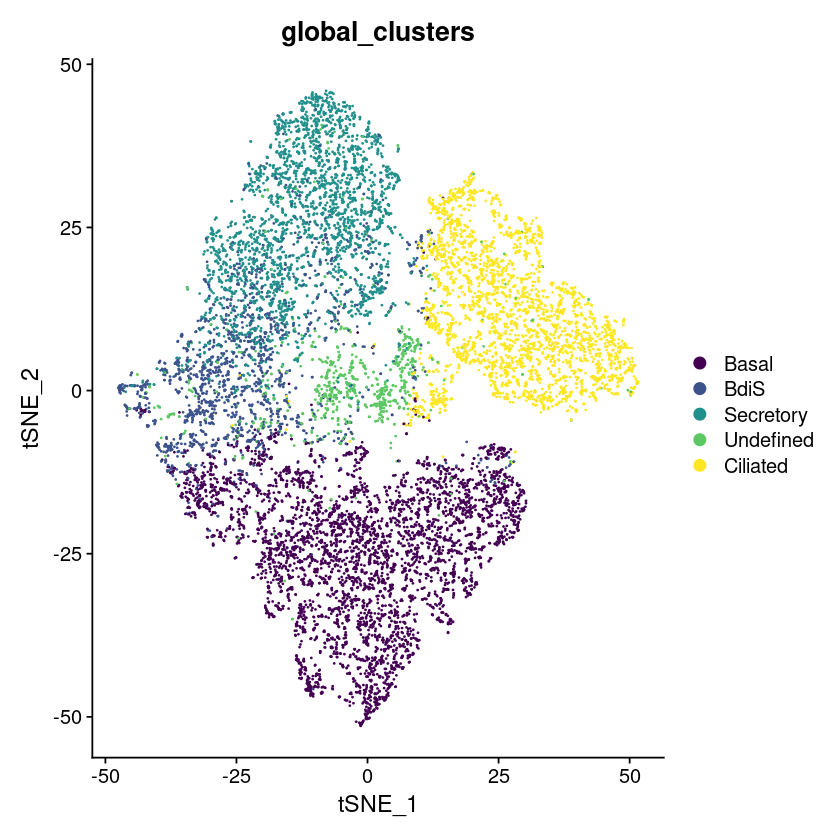

In [18]:
### Plot
DimPlot(filtered, group.by='global_clusters', reduction = 'tsne_pcs')